In [13]:
import scipy
import numpy as np
import random
import uncertainties
from uncertainties import ufloat
import pandas as pd
import matplotlib.pyplot as plt
from constants import *

def dur_tot_calc(p, b, ror, rho, e=0., w=0.):
    '''
    Solves for total duration T14 (in days)
    From Winn 2010, Eq 14 with eccentricity consideration from Eq 16
    Approximations used: sin(i) ~ 1, arcsin(x) ~ x
    Args:
        p: period (days)
        b: impact parameter
        rho: stellar density or circular stellar density (g/cc)
        e: eccenticity - if true stellar density is input; default 0
        w: omega, argument of periastron (radians) - if true stellar density is input; default 0
        ror: Rp/Rs
    Returns:
        T14: total transit duration 1->4 (in days)
    '''
    p *= day
    aor = ((p**2 * G * rho) / (3 * np.pi))**(1/3)
    f_ew = ((1-e**2)**(1/2)/(1+e*np.sin(w)))
    dur_tot = p/np.pi * aor**(-1) * ((1+ror)**2 - b**2)**(1/2) * f_ew
    return dur_tot/day


# Select baseline system parameters

In [14]:

per_inj = 5.
t0_inj = 0.

ror_inj = 0.05
b_inj = 0.3

e_inj = 0.1
w_inj = np.pi/2.

rho_test = rhosun
rho_test_err = rhosun*0.1

dur_inj = dur_tot_calc(per_inj, b_inj, ror_inj, rho_test, e_inj, w_inj)

params = {'period': per_inj,
         't0': t0_inj,
         'dur': dur_inj,
         'ror': ror_inj,
         'b': b_inj,
         'e': e_inj,
         'omega': w_inj,
         'rho_star': rho_test}

params



{'period': 5.0,
 't0': 0.0,
 'dur': 0.1177221267616729,
 'ror': 0.05,
 'b': 0.3,
 'e': 0.1,
 'omega': 1.5707963267948966,
 'rho_star': 1.409779824307527}

# Sample from uniform distributions for N samples

In [15]:
N = int(1e5)

rhocirc_uni = np.random.uniform(0.01, 10.0, N)
ror_uni = np.random.uniform(0.001, 1.0, N)
b_uni = np.random.uniform(0.0, 1.0, N)

#b_uni = np.array([np.random.uniform(0, 1+ror, 1)[0] for ror in ror_uni])

# Get derived total duration (T14_0) given uniform rhocirc, ror, and b

In [16]:
# set true value of T14 and its known error
T14 = dur_inj
sig_T14 = T14 * 0.1

# period is fixed
T14_0 = dur_tot_calc(per_inj, b_uni, ror_uni, rhocirc_uni)

# calculate chi-squared
chi2_T14 = ((T14 - T14_0) / sig_T14)**2

# calculat log-likelihood
logL = -0.5 * chi2_T14


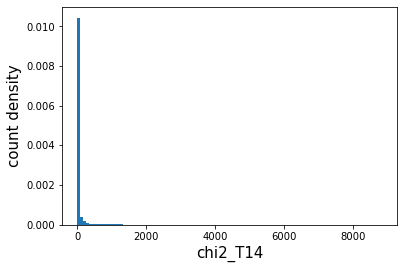

In [17]:
# Distribution of chi2_T14 values
plt.hist(chi2_T14, bins=100, density=True)
plt.ylabel('count density', fontsize=15)
plt.xlabel('chi2_T14', fontsize=15);

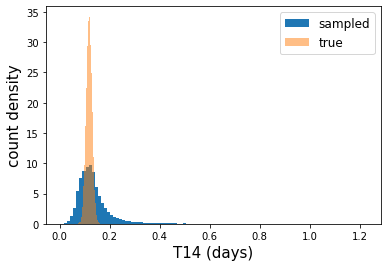

In [18]:
# Known distribution of T14 with 10% errorbars
T14_true = np.random.normal(T14, sig_T14, N)

# Plot sampled distribution vs. known distribution
plt.hist(T14_0, bins=100, density=True, label='sampled')
plt.hist(T14_true, bins=100, density=True, label='true', alpha=0.5)
plt.legend(fontsize=12)
plt.ylabel('count density', fontsize=15)
plt.xlabel('T14 (days)', fontsize=15);

Not bad, but there's definitely much broader tails on the sampled distribution of T14_0 than the true distribution

# Changing the range of rhocirc changes the outcome

The sampled distribution of T14_0 changes significantly depending on the range sampled for rhocirc_uni

Here, the upper bound of rhocirc_uni is changed from 10 g/cc to 50 g/cc (it is possible to attain such high rhocirc values for highly eccentric orbits)

In [19]:
# change range of rhocirc_uni
rhocirc_uni = np.random.uniform(0.01, 50.0, N)

# recalculate derived distribution of T14_0, along with chi-squared and log-likelihood
T14_0 = dur_tot_calc(per_inj, b_uni, ror_uni, rhocirc_uni)
chi2_T14 = ((T14 - T14_0) / sig_T14)**2
logL = -0.5 * chi2_T14

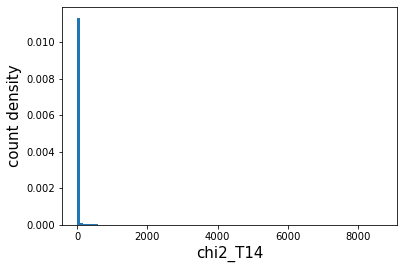

In [20]:
# Distribution of chi2_T14 values; rhocirc_uni: 0. --> 50.
plt.hist(chi2_T14, bins=100, density=True)
plt.ylabel('count density', fontsize=15)
plt.xlabel('chi2_T14', fontsize=15);

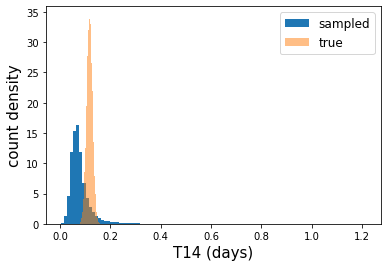

In [21]:
# Compare sampled distribution of T14 vs. true distribution; rhocirc_uni: 0. --> 50.
plt.hist(T14_0, bins=100, density=True, label='sampled')
plt.hist(T14_true, bins=100, density=True, label='true', alpha=0.5)
plt.legend(fontsize=12)
plt.ylabel('count density', fontsize=15)
plt.xlabel('T14 (days)', fontsize=15);

This sampled distribution is now significantly biased away from the known distribution of T14

# Is there a bias to impact parameter then?

We know T14 to 10% precision and ror to 10% precision

Assuming we fix the period and uniformly sample rhocirc_uni, we can solve for the distribution of b

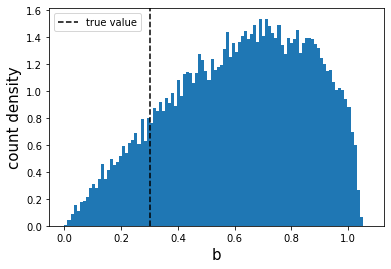

In [27]:
N = int(1e5)

# Sample from uniform distributions for N samples
ror_true = np.random.normal(ror_inj, ror_inj*0.1, N)
T14_true = np.random.normal(dur_inj, dur_inj*0.1, N)

rhocirc_uni = np.random.uniform(0.01, 10.0, N)

# Deriving b by rearranging the T14 (dur_tot) equation
# Using ror_true and T14_true distributions
aor = (((per_inj*day)**2 * G * rhocirc_uni) / (3 * np.pi))**(1/3)
bsquared_0 = ( (1+ror_true)**2 - (T14_true*(np.pi/per_inj)*aor)**2 )
pos = (bsquared_0 > 0)

# Plot distribution of b
plt.figure()
plt.hist(bsquared_0[pos]**(1/2), bins=100, density=True, range=(0.,1.+np.max(ror_true)))
plt.xlabel('b', fontsize=15)
plt.ylabel('count density', fontsize=15)
plt.axvline(b_inj, color='k', ls='--', label='true value')
plt.legend()
plt.show()


Interesting distribution. Definitely biased, but not too sure how to interepret this; also the bias is oddly towards higher impact parameter rather than lower? Which seems backwords to me

The math can be verified by constraining rhocirc_uni to be around the true value of rhocirc (which is given in the cell below) and seeing the distribution of b approach the true value

In [24]:
rhocirc_true = ((1-e_inj**2)**(1/2)/(1+e_inj*np.sin(w_inj)))**(-3)*rho_test
rhocirc_true

1.904919179876055

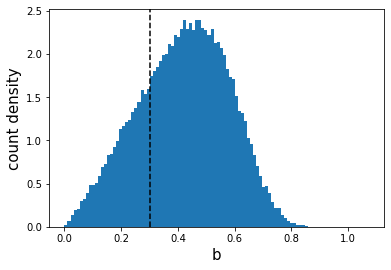

In [28]:
# Assume a 10% Gaussian error around rhocirc_true
rhocirc_uni = np.random.normal(rhocirc_true, rhocirc_true*0.1, N)

# Same as before
aor = (((per_inj*day)**2 * G * rhocirc_uni) / (3 * np.pi))**(1/3)
bsquared_0 = ( (1+ror_true)**2 - (T14_true*(np.pi/per_inj)*aor)**2 )
pos = (bsquared_0 > 0)

# Plot distribution of b
plt.figure()
plt.hist(bsquared_0[pos]**(1/2), bins=100, density=True, range=(0.,1.+np.max(ror_true)))
plt.xlabel('b', fontsize=15)
plt.ylabel('count density', fontsize=15)
plt.axvline(b_inj, color='k', ls='--', label='true value')
plt.show()

The distribution closes in on the true value of b when we constrain the rhocirc distribution around the true value, which makese sense. If we constrain this, ror, and T14 more, then it converges around the true b even more tightly